In [24]:
# Converted by Tim Stols
# python Explainer_Experiments.py --model_name CMPNN \
#                                                        --attribution_name GradInput \
#                                                        --data_path ../MolRep/Datasets/Metabolism/admet2.1_rlm_merge.csv \
#                                                        --dataset_name RLM \
#                                                        --smiles_col COMPOUND_SMILES \
#                                                        --target_col CLF_LABEL \
#                                                        --task_type Multi-Classification \
#                                                        --multiclass_num_classes 3 \
#                                                        --output_dir ../Outputs

In [25]:
import gc
from datetime import datetime

OUTPUT_DIR = f'../Outputs/{datetime.now().strftime("%Y%m%d_%H%M%S")}'
# OUTPUT_DIR = '../Outputs' # original output path, overwrites results
DATASET = 'Benzene'

# GNN
MODEL = 'CMPNN' # Options:  ['MPNN', 'DMPNN', 'CMPNN', 'GIN', 'ECC', 'GAT', 'DGCNN', 'DiffPool', 'GraphSAGE', 'GraphNet']

# explainer
ATTRIBUTION = 'IG' # Options: IG CAM MCTS GradInput GradCAM RandomBaseline

DATAPATH = '../Datasets/XAI/Benzene/benzene_smiles.csv'
SMILESCOL = 'SMILES'
TARGETCOL = 'label'

ATTRIBUTIONPATH = '../Datasets/XAI/Benzene/attributions.npz'

TASKTYPE = 'Classification' # Can be 'Multi-Classification', 'Classification', 'Regression'
MULTICLASS_NUM_CLASSES = 2 # Can be 3
TESTING = True
SPLITTYPE = 'defined' # Can be 'random', 'scaffold', or other defined for dataset

In [26]:
import rdkit.Chem
from MolRep.Utils.logger import Logger
from MolRep.Explainer.explainerExperiments import ExplainerExperiments
from MolRep.Explainer.explainerDataWrapper import ExplainerDatasetWrapper
from MolRep.Utils.config_from_dict import Grid, Config, DatasetConfig
from pathlib import Path
import os
from numba.cuda import args

LOGGER_BASE = os.path.join(OUTPUT_DIR, "Logger", f"{DATASET}_explainer")
logger = Logger(str(os.path.join(LOGGER_BASE, f"{MODEL}_{DATASET}_explainer_by_{ATTRIBUTION}.log")), mode='a')

# output for vector groups
data_dir = Path('../MolRep/Data')
split_dir = Path('../MolRep/Splits')
os.makedirs(data_dir, exist_ok=True)
os.makedirs(split_dir, exist_ok=True)

# torch.set_num_threads(1)")
data_stats = {
            'name': DATASET,
            'path': DATAPATH,
            'smiles_column': SMILESCOL,
            'target_columns': [TARGETCOL],
            'attribution_path': ATTRIBUTIONPATH,
            'task_type': TASKTYPE,
            'multiclass_num_classes': MULTICLASS_NUM_CLASSES,
            'metric_type': 'rmse' if TASKTYPE == 'Regression' else ['acc', 'auc', 'f1', 'precision', 'recall'],
            'split_type': SPLITTYPE
}

if TESTING:
    data_stats['additional_info'] = {"splits":'SPLIT'}

In [27]:
config_file = '../MolRep/Configs/config_{}.yml'.format(MODEL)
model_configurations = Grid(config_file)
model_configuration = Config(**model_configurations[0])
dataset_configuration = DatasetConfig(DATASET, data_dict=data_stats)

CMPNN
{'GIN': <class 'MolRep.Models.graph_based.GIN.GIN'>, 'ECC': <class 'MolRep.Models.graph_based.ECC.ECC'>, 'DGCNN': <class 'MolRep.Models.graph_based.DGCNN.DGCNN'>, 'DiffPool': <class 'MolRep.Models.graph_based.DiffPool.DiffPool'>, 'GraphSAGE': <class 'MolRep.Models.graph_based.GraphSAGE.GraphSAGE'>, 'GAT': <class 'MolRep.Models.graph_based.GAT.GAT'>, 'GraphNet': <class 'MolRep.Models.graph_based.GraphNet.GraphNet'>, 'MPNN': <class 'MolRep.Models.graph_based.MPNN.MPNN'>, 'CMPNN': <class 'MolRep.Models.graph_based.CMPNN.CMPNN'>, 'DMPNN': <class 'MolRep.Models.graph_based.DMPNN.DMPNN'>, 'MAT': <class 'MolRep.Models.sequence_based.MAT.MAT'>, 'CoMPT': <class 'MolRep.Models.sequence_based.CoMPT.CoMPT'>, 'BiLSTM': <class 'MolRep.Models.sequence_based.BiLSTM.BiLSTM'>, 'SALSTM': <class 'MolRep.Models.sequence_based.SALSTM.SALSTM'>, 'Transformer': <class 'MolRep.Models.sequence_based.Transformer.Transformer'>, 'VAE': <class 'MolRep.Models.unsupervised_based.VAE.VAE'>, 'RandomForest': <class

In [28]:
###### graphics go here
svg_dir = os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer", "SVG", f"{ATTRIBUTION}_{model_configuration['num_epochs']}_epochs")

# model output
output_dir = Path(OUTPUT_DIR)
MODELPATH = os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer", f"{MODEL}.pt")
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(svg_dir, exist_ok=True)

In [29]:
# export path: model + dataset name
exp_path = os.path.join(output_dir, f'{model_configuration.exp_name}_{dataset_configuration.exp_name}_explainer')

# dataset_config: configuration of the model
# model_name: name of the model
# split_dir: path to defined splits of the dataset
# features_dir: path to data directory
dataset = ExplainerDatasetWrapper(dataset_config=dataset_configuration,
                                  model_name=model_configuration.exp_name,
                                  split_dir=split_dir, features_dir=data_dir)


In [30]:
# perform explainer experiment using the model and data config
# also trains the model?
explainer_experiment = ExplainerExperiments(model_configuration, dataset_configuration, exp_path)

# validation
explainer_experiment.run_valid(dataset, ATTRIBUTION, logger=logger, other={'model_path':MODELPATH})
# if not os.path.exists(MODELPATH):
#     explainer_experiment.run_valid(dataset, ATTRIBUTION, logger=logger, other={'model_path':MODELPATH})

[TRAIN] Epoch: 1, train loss: 0.666495 train acc: 0.717167
[TRAIN] Metric:{'acc': 0.7171666666666666, 'auc': 0.8083016752306021, 'f1': 0.747395058052992, 'precision': 0.6753194351042368, 'recall': 0.8366938843526079}
[VALID] Metric:-1
[TEST] Metric:None
- Elapsed time: 20.7s , Time estimation in a fold: 0.34min


(None, None)

Moving model to cuda


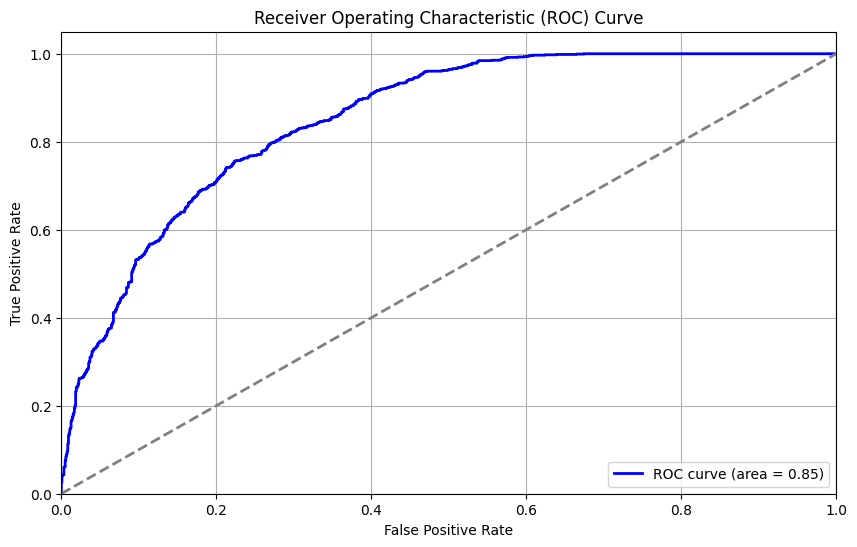

(2400, 3)
..\Outputs\20240529_122238\CMPNN_Benzene_explainer\CMPNN_explained_by_IG_oof.csv


In [31]:
# generate results from the dataset using defined explanation method, using a trained model
results, atom_importance, bond_importance = explainer_experiment.molecule_importance(dataset=dataset, attribution=ATTRIBUTION, logger=logger, other={'model_path':MODELPATH}, testing=TESTING)

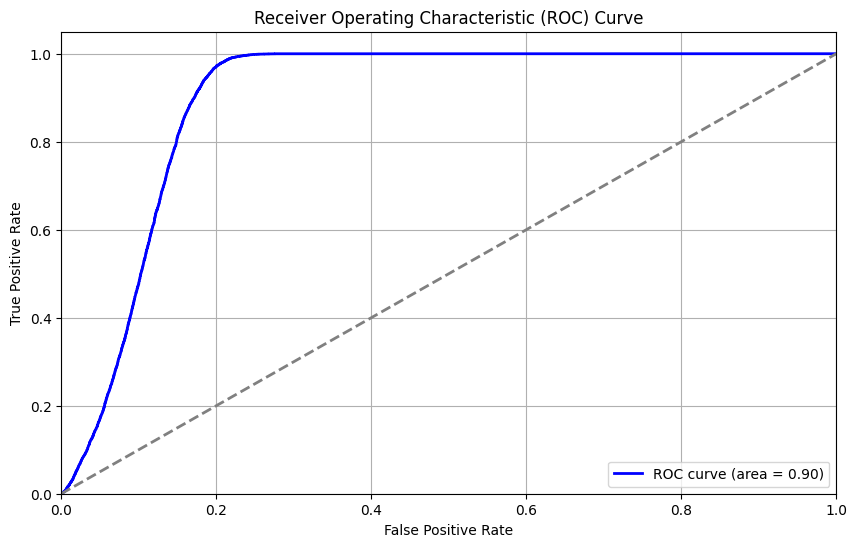

In [32]:
import pandas as pd

# logger.log('Test results: %s' % str(results))

# print(attribution_results)

if DATASET in ['hERG', 'CYP3A4']:
    attribution_results, opt_threshold = explainer_experiment.evaluate_cliffs(dataset, atom_importance, bond_importance)
else:
    binary = True if ATTRIBUTION == 'MCTS' else False
    #TODO "not working, because ATTRIBUTIONPATH is not set and attributions are not saved"
    attribution_results, opt_threshold = explainer_experiment.evaluate_attributions(dataset, atom_importance, bond_importance, binary=binary)

In [33]:
#TODO "not working"
# logger.log('attribution_results:' + str(attribution_results))
# logger.log('opt_threshold:' + str(opt_threshold))

 
# creates visualizations from the datasets and outputs them to svg_dir
explainer_experiment.visualization(dataset, atom_importance, bond_importance, svg_dir=svg_dir, testing=TESTING)

df = pd.DataFrame(
    {'SMILES': dataset.get_smiles_list(), 'Atom_importance': atom_importance, 'Bond_importance':bond_importance}
)
df.to_csv(os.path.join(svg_dir, "importances.csv"), index=False)

In [34]:
import pprint

pp = pprint.PrettyPrinter(indent=1)
print(model_configuration['num_epochs'])
print(results['acc'])
print(results['auc'])
print(results['f1'])
print(results['precision'])
print(results['recall'])
print()
print(attribution_results['Attribution AUROC'])
print(attribution_results['Attribution F1'])
print(attribution_results['Attribution ACC'])
print(attribution_results['Attribution Precision'])
print(attribution_results['Attribution AUROC Mean'])
print(attribution_results['Attribution ACC Mean'])

1
0.75375
0.8511135310675411
0.7782363977485929
0.7132049518569463
0.856317093311313

0.9500713416703155
0.0
0.8153212876847543
0.0
0.896835145704458
0.8046728026701729


In [35]:
import copy

# path to model and explanations
# EXPERIMENT_MODEL = '../Outputs/20240524_164403/CMPNN_Benzene_explainer/CMPNN.pt'
# IMPORTANCES_PATH = '../Outputs/20240524_164403/CMPNN_Benzene_explainer/SVG/IG_1_epochs/importances.csv' 
# DATAFRAME = pd.read_csv(IMPORTANCES_PATH)

# def split_molecule(mol_idx:int, threshold=1e-4, df=DATAFRAME):
def split_molecule(mol_idx:int, threshold=1e-4):
    """Splits the given molecule into explaining and non-explaining SMILES, returns those and the SMILES of the molecule. Threshold value is the same as in explainerExperiments.py visualization()"""
    smile = df.SMILES.iat[mol_idx]

    # TODO get test indices, index by the index in the test set?
    importances = df.Atom_importance.iat[mol_idx]

    original_mol = rdkit.Chem.RWMol(rdkit.Chem.MolFromSmiles(smile))
     
    non_explaining_atom_idxs = []
    explaining_atom_idxs = []
    for idx in range(len(original_mol.GetAtoms())):
        if importances[idx] < threshold:
            non_explaining_atom_idxs.append(idx)
        else:
            explaining_atom_idxs.append(idx)
            
    # reverse because removing atoms causes indices of others to shift
    non_explaining_atom_idxs.reverse()
    explaining_atom_idxs.reverse()
    
    # find (non)explaining bonds where at least one end is a non-explaining atom
    non_explaining_bonds = []
    explaining_bonds = []
    
    for bond in original_mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        
        # if both end and start in explaining atoms, the edge is explaining 
        if (i and j) not in non_explaining_atom_idxs :
            explaining_bonds.append((i, j))
            explaining_bonds.append((j, i))
        else:
            non_explaining_bonds.append((i, j))
            non_explaining_bonds.append((j, i))
            
            # remove i or j from explaining atoms 
            # so bonds between explaining and nonexplaining atoms are kept in non-explaining molecules
            if i in explaining_atom_idxs: explaining_atom_idxs.remove(i)
            if j in explaining_atom_idxs: explaining_atom_idxs.remove(j)
    
    # explaining molecule has non-explaining bonds and atoms removed
    explaining_mol = copy.deepcopy(original_mol)
    for (i, j) in non_explaining_bonds:
        explaining_mol.RemoveBond(i, j)
    
    for idx in non_explaining_atom_idxs:
        explaining_mol.RemoveAtom(idx)

    explaining_smile = rdkit.Chem.MolToSmiles(explaining_mol)
    
    # comprehensiveness uses non-explaining atoms and edges
    non_explaining_mol = copy.deepcopy(original_mol)
    
    for (i, j) in explaining_bonds:
        non_explaining_mol.RemoveBond(i, j)
    
    # remove explaining atoms    
    for i in explaining_atom_idxs:
        non_explaining_mol.RemoveAtom(i)
    
    non_explaining_smile = rdkit.Chem.MolToSmiles(non_explaining_mol)
    
    return smile, explaining_smile, non_explaining_smile

In [36]:
import torch
from MolRep.Featurization.MPNN_embeddings import MolGraph, BatchMolGraph
from rdkit.Chem import MolFromSmiles, rdmolops

def tensors_to_device(smile, batch):
    """Sets nodes, edges, a2b, b2a and adjacency matrix tensors of a molecule to the device"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    adj = rdmolops.GetAdjacencyMatrix(MolFromSmiles(smile))
    
    list = {
        'nodes' : batch.f_atoms, 
        'edges' : batch.f_bonds,
        'a2b' : batch.a2b,
        'b2a' : batch.b2a,
        'adjacency' : torch.FloatTensor(adj) 
    }
    
    for i in list:
        list[i].to(device)
        
    return list['nodes'], list['edges'], list['a2b'], list['b2a'], list['adjacency']

In [37]:
import re
def clean_smile(s:str) -> str:
    """Takes a (fragmented) SMILES as input and returns valid fragments of it as a new SMILES. Does nothing if input is already valid.
    e.g: C.CC.F.O.n.n -> C.CC.F.O
    """
    cs = ""
    # 1. split n/explanations into a list
    subm = s.split('.')
    
    # 2. try to convert the pieces into a molgraph
    # if success, append to a new string cs (cut string)
    for (i, sm) in enumerate(subm): 
        try:
            MolGraph(sm)
            cs += sm
            if i < len(subm) - 1:
                cs += '.'
        except:
            if i < len(subm) - 1:
                cs += '.'
            continue
        
    # remove repetitions and the last period from the string
    cs = re.sub("\.+", ".", cs)
    # ReGeX from https://stackoverflow.com/a/3331982
    cs = re.sub("\.([^.]*)$", "", cs)
    return cs


In [52]:
def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

EXPERIMENT_MODEL = MODELPATH
def comp_and_suff(i) :
    """Calculate comprehensiveness and sufficiency for a molecule with index i."""
    # TODO move this out so no need to get the same model every time
    
    model = explainer_experiment.get_model(dataset, other={'model_path':EXPERIMENT_MODEL})
    model.eval() # set model to evaluation mode

    smile, explaining_smile, non_explaining_smile = split_molecule(i)
    # print(smile, explaining_smile, non_explaining_smile)
    
    # TODO create an object of the index of mol, original smile, n/explaining ones, clean ones, original prediction, explaining preds, nexplaining preds , comp and suff
    
    # clean up the smiles, split may have created invalid molecules
    clean_smiles = map(clean_smile, [smile, explaining_smile, non_explaining_smile])

    preds = []
    for cs in clean_smiles:
        # if cs is empty, don't predict it
        if cs == "":
            # if no non-explaining, then comp is f(g) = great, because the whole molecule explains the prediction!
            # if no explaining, suff is f(g) = maybe good?, because there's nothing to explain why prediction was made?
            
            # none to begin with != none being valid
            preds.append(0)
            continue
        
        # 3. convert cs to molgraph
        # TODO if iterating (non)explaining smiles -> do each fragment separately
        # can do all separately, because original is just one
        try :
            mol = MolGraph(cs)
            g_input = BatchMolGraph( [mol])
            atoms, bonds, a2b, b2a, adjacency = tensors_to_device(cs, g_input)
    
            with torch.no_grad():
                # TODO investigate None params?
                #   Args for mol2graph:
                # - mols: A list of SMILES or a list of RDKit molecules.
                # - atom_descriptors_batch: A list of 2D numpy array containing additional atom descriptors to featurize the molecule
                pred = model([[cs], None, None]).item()
                # print(pred)
    
            # print(i, ' pred for ', cs, ': ', pred)
            preds.append(pred)
        except:
            # I don't know why this would happen, but apparently it does happen
            preds.append(None)
            

    g_pred = preds[0] # prediction of original molecule
    e_pred = preds[1] # prediction of explaining molecules - take the mean
    n_pred = preds[2] # prediction of non-explaining molecules - sum

    # f = model prediction given a smile
    # comp = f(smile) - f(non_explaining_smile)
    # suff = f (smile) - f(explaining_smile)

    comp = g_pred - n_pred if n_pred is not None else None
    suff = g_pred - e_pred if e_pred is not None else None

    return [g_pred, comp, suff]

In [53]:
def comp_and_suff_data(df):
    """Calculates and accumulates the comprehensiveness and sufficiency for all molecules within the test set of the dataset."""
    c_and_s = []

    for i in range(len(df)):
        clear_gpu_memory()
        # only calculate comp and suff for molecules in the test set i.e. which have explanations
        if i in dataset.get_smiles_idxs(testing=True):
            vals = comp_and_suff(i)
            c_and_s.append(vals)
    return c_and_s

g_pred, comp, suff = comp_and_suff(3)
print('g_pred: ', g_pred)
print('comp:', comp)
print('suff:', suff)

# TODO average out the results:
# comp is avg difference between orig and n_pred
# suff is avg suff
c = comp_and_suff_data(df)

# print(c)

Moving model to cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 

In [114]:
# TODO 2 further work
# save results of comp-suff for transparency
# use a different explainer on the model
# save those results